<a href="https://colab.research.google.com/github/raultyv/Machine_learning/blob/main/RF_Cobre_fino_MLB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## 1. CARGA DEL DATASET
import pandas as pd #basico para trabajar data tabular como en excel
import numpy as np # usado para calculos numericos
from google.colab import files #permite subir archivos manualmente

uploaded = files.upload() #para subir archivos
filename = list(uploaded.keys())[0] #extrae el nombre del primer archivo subido
df = pd.read_excel(filename) #lee el excel data y crea un data frame
df.head() #visualizacion de las primeras 5 filas,  verifica que se ha cargado la data

## 2. ESTANDARIZACIÓN Y TIPOS
df.columns = [c.replace('Real Diario', 'Fecha').replace(' ', '_').replace('(', '').replace(')', '').replace('%', 'Pct').replace('.', '') for c in df.columns] #para normalizar nombres de columnas, sin espacios, sin simbolos

for col in df.columns:
    if col != 'Fecha': #evita tocar la fecha
        df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', '.'), errors='coerce') #fuerza y limpia todas las variables (salvo la fecha) a numericas
        #primero convierte todo a string, permite aplicar el str.replace (util cuando la data mezcla numero y texto), convertimos a formato europeo de 0,2  a 0.2 todos los datos, pd.numeric convierte a numero, si no puede pone NaN

## 3. UNIFICACIÓN DE ESCALAS Y UNIDADES (Lo que ya validamos)
cols_pct = [c for c in df.columns if 'Pct' in c or 'Ley' in c or 'Rec' in c or 'Tox' in c] #lista de nombres con variables que representan porcentajes
for col in cols_pct:
    df[col] = np.where(df[col] > 1.1, df[col] / 100.0, df[col]) #normalizacion automatica, evita porcentajes mayores a 100% (absurdos)

# Sincronizar Fino Recuperado con Filtrado (x100)
if df['Cu_Fino_Recuperado_t'].mean() < 50: # si la variables tiene un promedio menor, se asume que esta en otra escala o en cientos de toneladas (en este caso)
    df['Cu_Fino_Recuperado_t'] = df['Cu_Fino_Recuperado_t'] * 100.0 #escala la variable

## 4. ELIMINACIÓN DE NULOS Y OUTLIERS FÍSICOS (Sin completar nada)
# Eliminamos cualquier día con datos faltantes (paradas de planta)
df_limpio = df.dropna().copy()

# Filtramos errores de sensor/digitación obvios que detectamos en el describe
df_limpio = df_limpio[
    (df_limpio['Ley_Pct'] <= 0.05) & # No existe ley de alimentación de 103% (1.03)
    (df_limpio['Tonelaje_Stock_Pile_Kt'] < 3000) & # Filtramos el stock pile de 9000
    (df_limpio['Rec_Pct'] > 0.1) # Si la recuperación es casi 0, no hay proceso real
]

print(f"Días con operación completa y válida: {len(df_limpio)}")
print("\n--- Estadísticas Finales para ML ---")
print(df_limpio.describe())

df_limpio.describe()
## conclusion: se observa un -10 en el stock pile lo cual no es correcto

## correccion
# Eliminamos las filas donde el Stock Pile sea negativo antes de cerrar el modelo
df_limpio = df_limpio[df_limpio['Tonelaje_Stock_Pile_Kt'] >= 0]

# Verificamos que el mínimo ahora sea 0 o superior
print(f"Nuevo mínimo de Stock Pile: {df_limpio['Tonelaje_Stock_Pile_Kt'].min()}")
print(df_limpio.describe())
## conclusion: verificado, correcto, no se esta imputando, se esta eliminando filas donde no hay procesos para ML predictivo.
df_limpio.head()

Saving informacion_planta.xlsx to informacion_planta.xlsx
Días con operación completa y válida: 2202

--- Estadísticas Finales para ML ---
                               Fecha  Chancado_Kt    Molido_Kt      Ley_Pct  \
count                           2202  2202.000000  2202.000000  2202.000000   
mean   2022-11-13 23:35:08.991825664   143.168495   142.974587     0.007381   
min              2019-07-01 00:00:00     0.000000     2.226490     0.003169   
25%              2021-03-24 06:00:00   134.520750   139.696641     0.005825   
50%              2022-12-18 12:00:00   153.572561   149.387774     0.007309   
75%              2024-06-27 18:00:00   165.055269   155.307033     0.008722   
max              2026-01-05 00:00:00   186.585592   186.130798     0.015757   
std                              NaN    36.164383    22.816586     0.002021   

           Tox_Pct      Rec_Pct  Rec_Modelo_Pct  Cu_Fino_Recuperado_t  \
count  2202.000000  2202.000000     2202.000000           2202.000000   
mea

,Fecha,Chancado_Kt,Molido_Kt,Ley_Pct,Tox_Pct,Rec_Pct,Rec_Modelo_Pct,Cu_Fino_Recuperado_t,Cu_Fino_Filtrado_t,Grado_Conc_Filtrado_Pct,PctFinos,Stock_Pile_Pct,Tonelaje_Stock_Pile_Kt,Humedad_de_Concentrado_Pct,Disponibilidad_Chancado_Pct,Uso_de_Disponibilidad_Chancado_Pct,Disponibilidad_Molienda_Pct,Uso_de_Disponibilidad_Molienda_Pct
30,2019-07-01,155.20,153.17,0.0067,0.0857,0.8606,0.8795,893.30,994.61,0.3555,0.280,0.980,949.91,0.0875,0.99,0.77,1.0,1.0
31,2019-07-02,146.35,156.58,0.0092,0.0710,0.9025,0.8933,1300.31,1182.65,0.3859,0.290,0.950,939.68,0.0815,0.97,0.76,1.0,1.0
32,2019-07-03,154.42,157.42,0.0081,0.0789,0.8973,0.8842,1158.99,1131.08,0.3897,0.290,0.930,936.68,0.0843,0.97,0.81,1.0,1.0
33,2019-07-04,141.33,151.97,0.0072,0.0813,0.9046,0.8835,1005.95,1009.38,0.3858,0.287,0.935,926.04,0.0790,0.81,0.86,1.0,1.0
34,2019-07-05,168.92,146.88,0.0096,0.0741,0.9010,0.8903,1291.42,1153.33,0.3935,0.285,0.987,948.08,0.0897,1.00,0.82,1.0,1.0


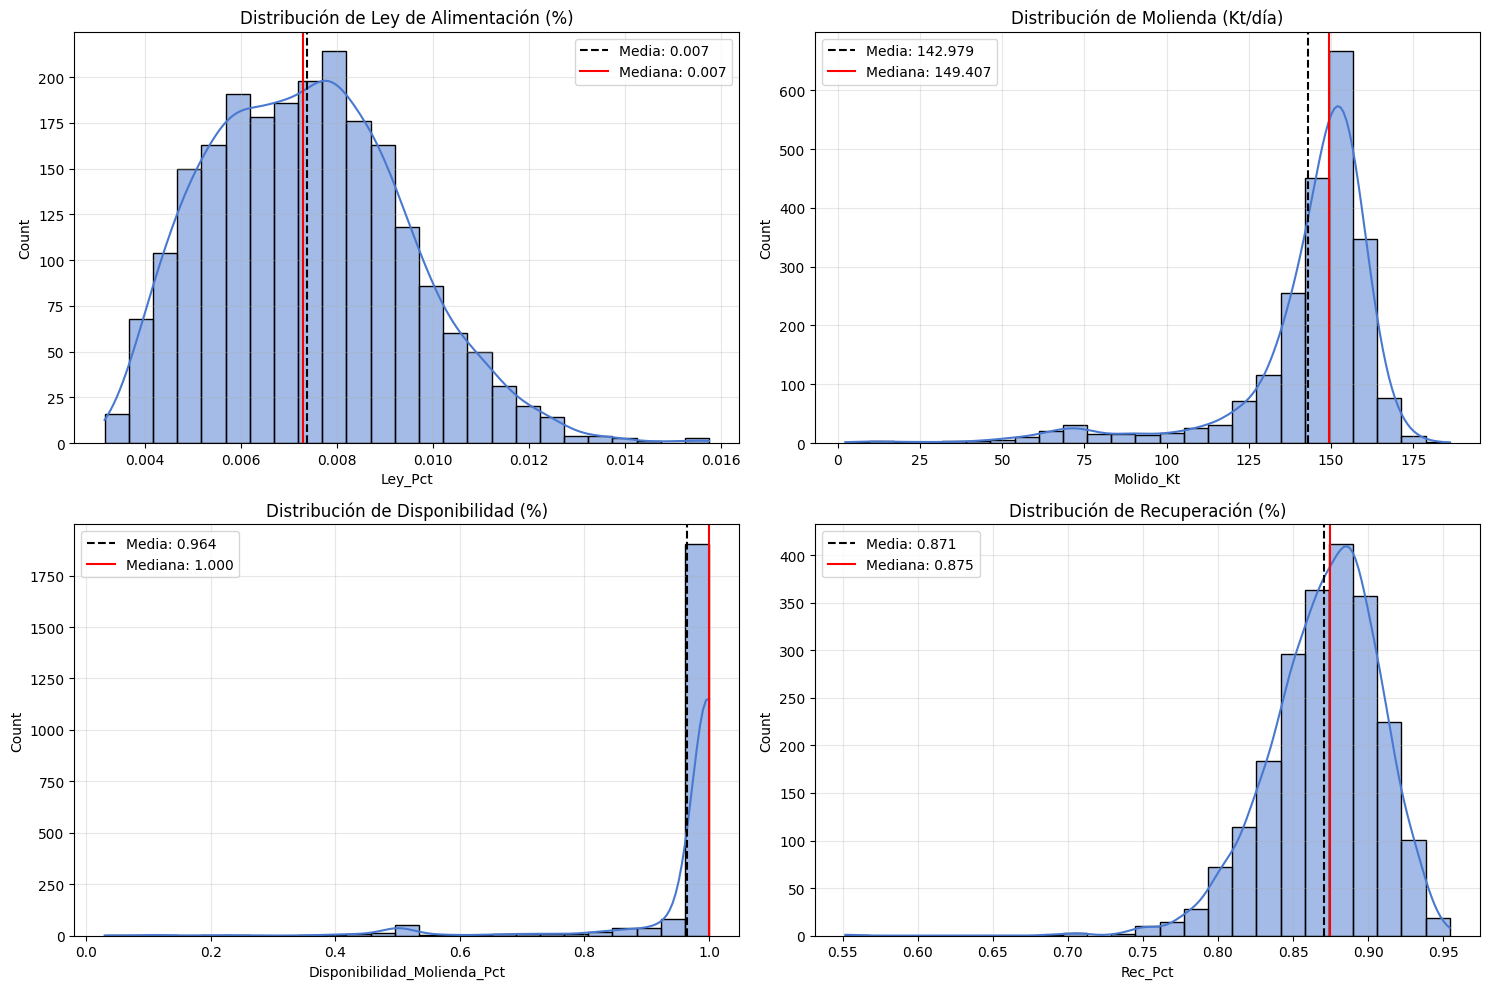

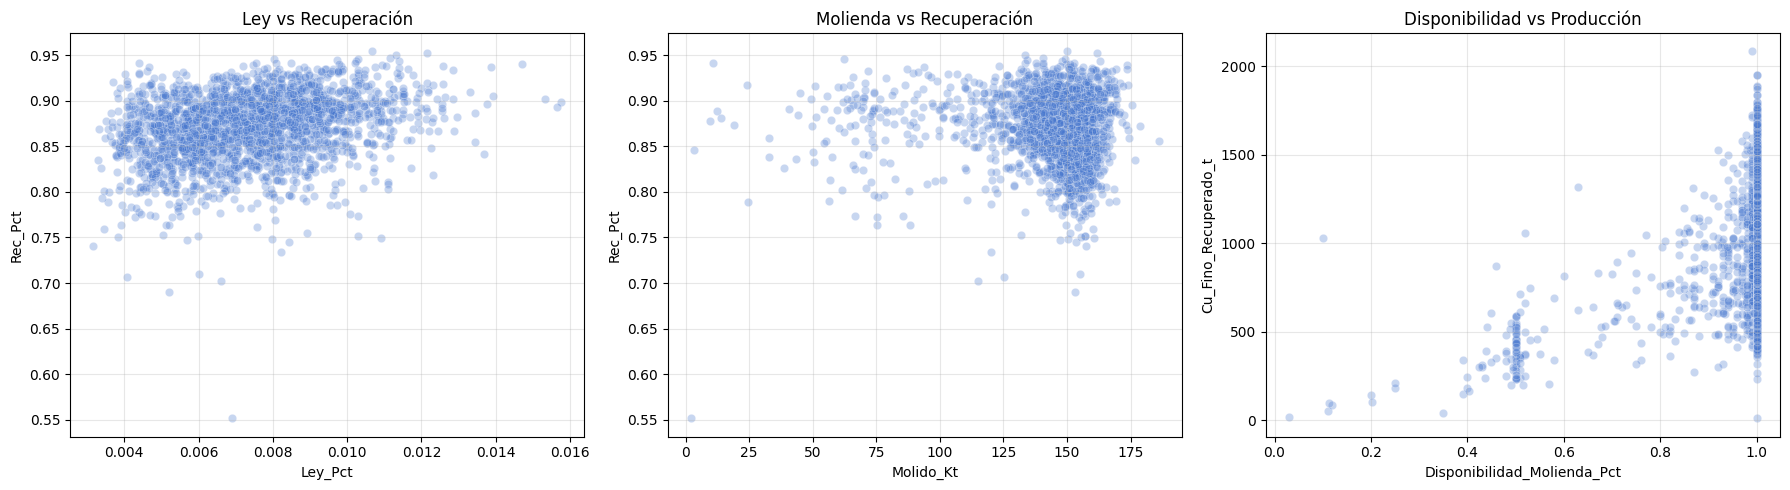

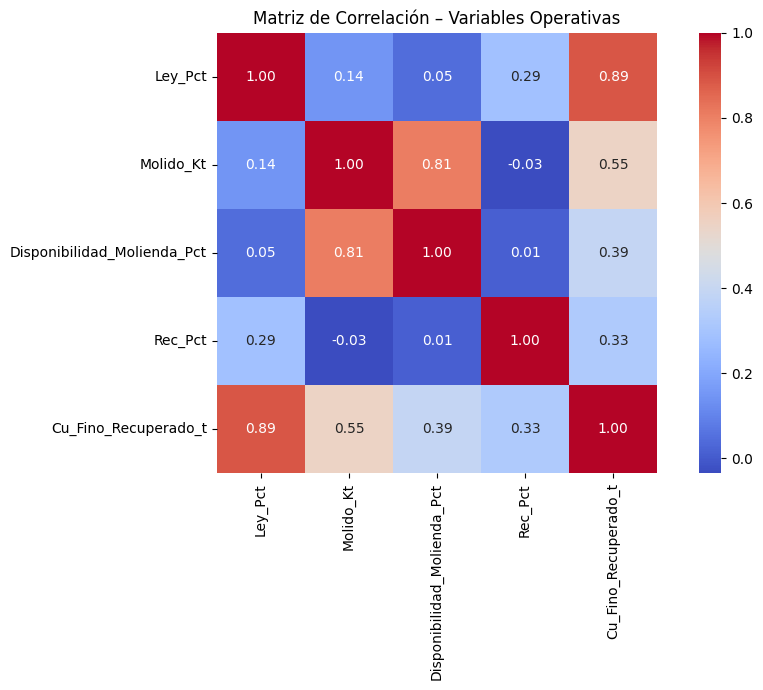

In [4]:
## EDA
# =========================
# EDA OPERATIVO CONSOLIDADO
# =========================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.style.use('seaborn-v0_8-muted')

# -------------------------
# 1. DISTRIBUCIONES
# -------------------------
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

variables = [
    ('Ley_Pct', 'Distribución de Ley de Alimentación (%)'),
    ('Molido_Kt', 'Distribución de Molienda (Kt/día)'),
    ('Disponibilidad_Molienda_Pct', 'Distribución de Disponibilidad (%)'),
    ('Rec_Pct', 'Distribución de Recuperación (%)')
]

for ax, (col, title) in zip(axs.flatten(), variables):
    sns.histplot(
        data=df_limpio,
        x=col,
        kde=True,
        bins=25,
        ax=ax
    )

    media = df_limpio[col].mean()
    mediana = df_limpio[col].median()

    ax.axvline(media, color='black', linestyle='--', label=f'Media: {media:.3f}')
    ax.axvline(mediana, color='red', linestyle='-', label=f'Mediana: {mediana:.3f}')

    ax.set_title(title)
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# -------------------------
# 2. RELACIONES OPERATIVAS
# -------------------------
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Ley vs Recuperación
sns.scatterplot(
    data=df_limpio,
    x='Ley_Pct',
    y='Rec_Pct',
    alpha=0.3,
    ax=axs[0]
)
axs[0].set_title('Ley vs Recuperación')
axs[0].grid(alpha=0.3)

# Molido vs Recuperación
sns.scatterplot(
    data=df_limpio,
    x='Molido_Kt',
    y='Rec_Pct',
    alpha=0.3,
    ax=axs[1]
)
axs[1].set_title('Molienda vs Recuperación')
axs[1].grid(alpha=0.3)

# Disponibilidad vs Producción
sns.scatterplot(
    data=df_limpio,
    x='Disponibilidad_Molienda_Pct',
    y='Cu_Fino_Recuperado_t',
    alpha=0.3,
    ax=axs[2]
)
axs[2].set_title('Disponibilidad vs Producción')
axs[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# -------------------------
# 3. MATRIZ DE CORRELACIÓN
# -------------------------
cols_corr = [
    'Ley_Pct',
    'Molido_Kt',
    'Disponibilidad_Molienda_Pct',
    'Rec_Pct',
    'Cu_Fino_Recuperado_t'
]

plt.figure(figsize=(10, 7))
sns.heatmap(
    df_limpio[cols_corr].corr(),
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    square=True
)
plt.title('Matriz de Correlación – Variables Operativas')
plt.tight_layout()
plt.show()



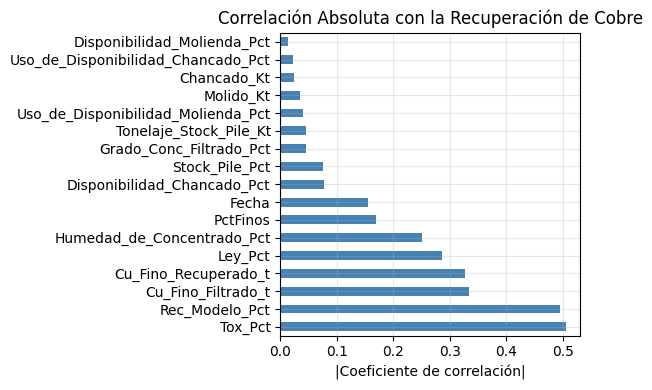

In [5]:
# Correlaciones absolutas con la variable objetivo (Recuperación)
target = 'Rec_Pct'

# Matriz de correlación solo con variables numéricas
correlation_matrix = df_limpio.corr()

# Correlación absoluta con la recuperación
corr_target = (
    correlation_matrix[target]
    .abs()
    .sort_values(ascending=False)
)

# Gráfico
plt.figure(figsize=(6, 4))
corr_target.drop(target).plot(kind='barh', color='steelblue')

plt.title('Correlación Absoluta con la Recuperación de Cobre')
plt.xlabel('|Coeficiente de correlación|')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


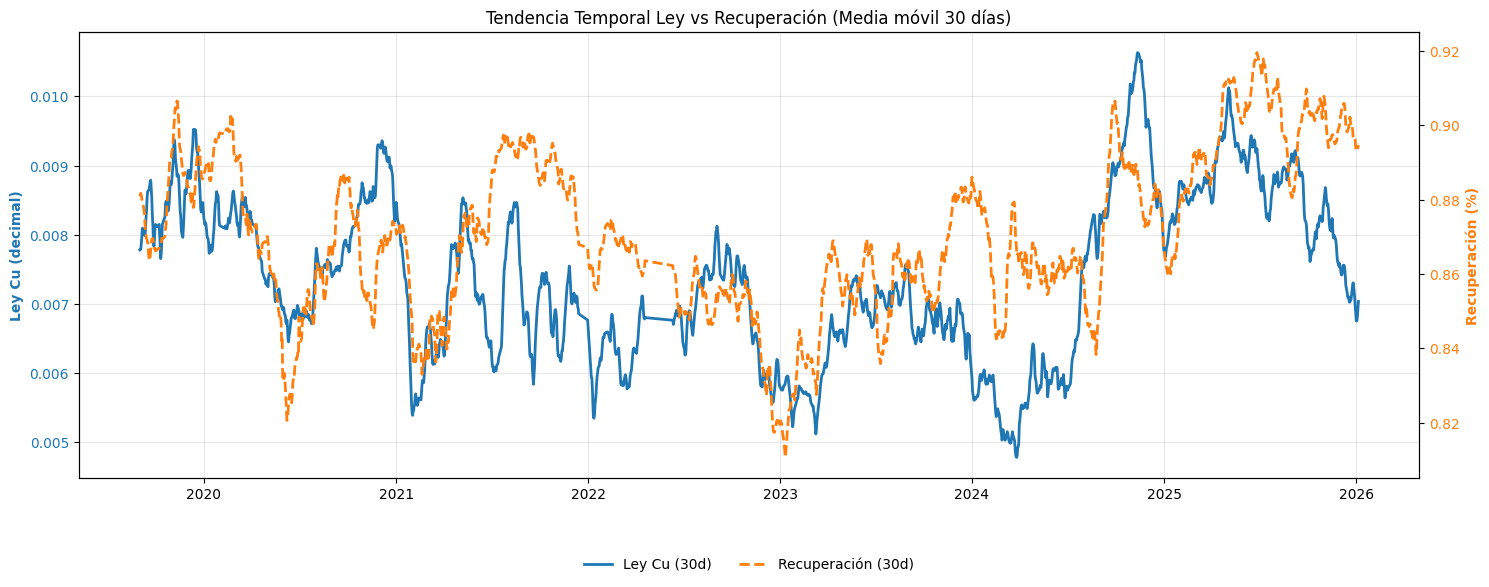

In [6]:
## analisis de tendencia temporal
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(15, 6))

# Ley
ax1.plot(
    df_limpio['Fecha'],
    df_limpio['Ley_Pct'].rolling(30).mean(), #media movil de 30 dias
    color='tab:blue',
    linewidth=2,
    label='Ley Cu (30d)'
)
ax1.set_ylabel('Ley Cu (decimal)', color='tab:blue', fontweight='bold')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Recuperación
ax2 = ax1.twinx()
ax2.plot(
    df_limpio['Fecha'],
    df_limpio['Rec_Pct'].rolling(30).mean(), #media movil de 30 dias
    color='tab:orange',
    linewidth=2,
    linestyle='--',
    label='Recuperación (30d)'
)
ax2.set_ylabel('Recuperación (%)', color='tab:orange', fontweight='bold')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# --- Leyenda debajo del eje X (Excel style) ---
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

ax1.legend(
    lines1 + lines2,
    labels1 + labels2,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=2,
    frameon=False,
    fontsize=10
)

plt.title('Tendencia Temporal Ley vs Recuperación (Media móvil 30 días)')
ax1.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [7]:
## operacion de molienda
# Umbrales basados en estadística
umbral_molienda = df_limpio['Molido_Kt'].quantile(0.7)
umbral_ley = df_limpio['Ley_Pct'].quantile(0.6)
umbral_rec = df_limpio['Rec_Pct'].median()

dias_potenciales = df_limpio[
    (df_limpio['Molido_Kt'] > umbral_molienda) &
    (df_limpio['Ley_Pct'] > umbral_ley)
]

dias_atipicos = dias_potenciales[
    dias_potenciales['Rec_Pct'] < umbral_rec
].sort_values(by='Rec_Pct')

print(f"Días con alto potencial y baja recuperación: {len(dias_atipicos)}")

dias_atipicos[['Fecha', 'Molido_Kt', 'Ley_Pct', 'Rec_Pct']].head(10)


Días con alto potencial y baja recuperación: 131


,Fecha,Molido_Kt,Ley_Pct,Rec_Pct
673,2021-05-05,160.770000,0.010900,0.749600
598,2021-02-19,157.157210,0.010296,0.751480
1191,2022-10-05,155.493393,0.008053,0.769615
672,2021-05-04,157.140000,0.010300,0.773100
341,2020-06-07,156.398450,0.010084,0.776240
137,2019-11-16,156.745143,0.007997,0.781810
1852,2024-07-27,166.399502,0.009929,0.788824
1853,2024-07-28,169.251544,0.008881,0.790128
1082,2022-06-18,154.201102,0.008798,0.793145
1267,2022-12-20,160.013605,0.008487,0.795408


Días con fugas operativas detectadas: 36


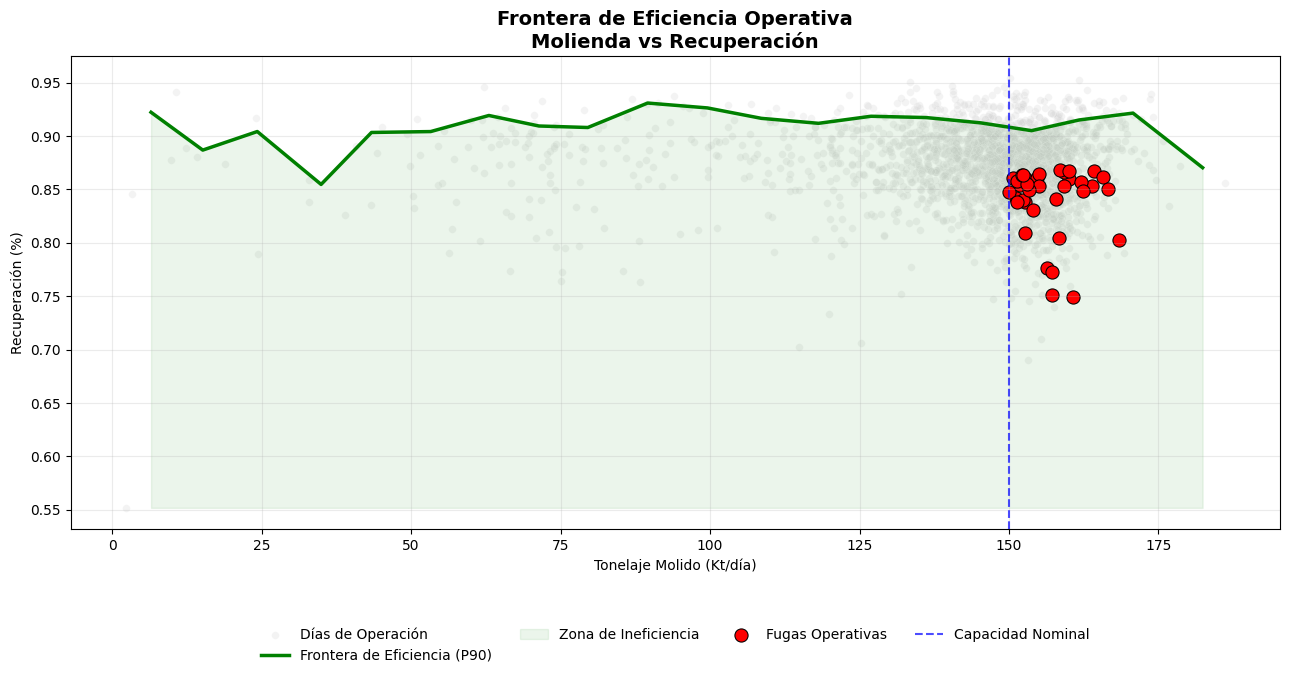

In [9]:
## frontera de la eficiencia
# ================================
# FRONTERA DE EFICIENCIA OPERATIVA
# ================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# 1. Definición de umbrales operativos
# -------------------------------
umbral_molienda = 150     # Kt/día
umbral_ley = 0.01         # 1%
umbral_rec = 0.87         # 87%

# -------------------------------
# 2. Identificación de anomalías operativas reales
# (Alta molienda + buena ley + baja recuperación)
# -------------------------------
df_limpio['Es_Atipico'] = (
    (df_limpio['Molido_Kt'] > umbral_molienda) &
    (df_limpio['Ley_Pct'] > umbral_ley) &
    (df_limpio['Rec_Pct'] < umbral_rec)
)

print(f"Días con fugas operativas detectadas: {df_limpio['Es_Atipico'].sum()}")

# -------------------------------
# 3. Construcción de la frontera de eficiencia (P90)
# -------------------------------
df_limpio['Molido_bin'] = pd.cut(df_limpio['Molido_Kt'], bins=20)

frontera = (
    df_limpio
    .groupby('Molido_bin', observed=True)
    .agg(
        Molido_Kt=('Molido_Kt', 'mean'),
        Rec_Pct=('Rec_Pct', lambda x: np.percentile(x, 90))
    )
    .dropna()
)

# -------------------------------
# 4. Gráfico integrado
# -------------------------------
plt.figure(figsize=(13, 7))

# Fondo histórico
sns.scatterplot(
    data=df_limpio,
    x='Molido_Kt',
    y='Rec_Pct',
    color='lightgray',
    alpha=0.25,
    s=30,
    label='Días de Operación'
)

# Frontera de eficiencia
plt.plot(
    frontera['Molido_Kt'],
    frontera['Rec_Pct'],
    color='green',
    linewidth=2.5,
    label='Frontera de Eficiencia (P90)'
)

# Zona de ineficiencia (bajo la frontera)
plt.fill_between(
    frontera['Molido_Kt'],
    frontera['Rec_Pct'],
    y2=df_limpio['Rec_Pct'].min(),
    color='green',
    alpha=0.08,
    label='Zona de Ineficiencia'
)

# Anomalías operativas
sns.scatterplot(
    data=df_limpio[df_limpio['Es_Atipico']],
    x='Molido_Kt',
    y='Rec_Pct',
    color='red',
    s=90,
    edgecolor='black',
    label='Fugas Operativas'
)

# Capacidad nominal
plt.axvline(
    umbral_molienda,
    color='blue',
    linestyle='--',
    linewidth=1.5,
    alpha=0.7,
    label='Capacidad Nominal'
)

# -------------------------------
# 5. Estética final
# -------------------------------
plt.title(
    'Frontera de Eficiencia Operativa\nMolienda vs Recuperación',
    fontsize=14,
    fontweight='bold'
)

plt.xlabel('Tonelaje Molido (Kt/día)')
plt.ylabel('Recuperación (%)')

plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.18),
    ncol=4,
    frameon=False
)

plt.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()




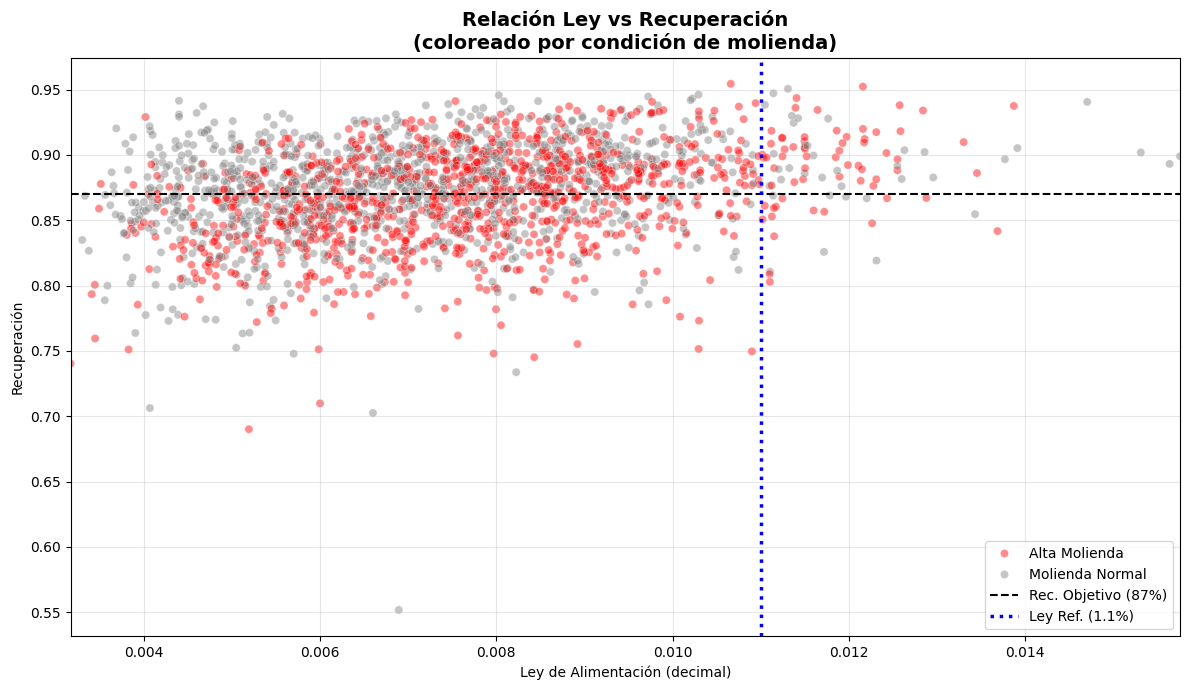

In [10]:
# ======================================
# SCATTER: LEY VS RECUPERACIÓN (CORREGIDO)
# ======================================

import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# PARÁMETROS CAMBIABLES
# -----------------------------
rec_objetivo = 0.87      # Recuperación objetivo (87%)
ley_ref = 0.011          # Ley de referencia (1.1%)
umbral_molienda = 150    # Capacidad nominal

# -----------------------------
# VARIABLE OPERATIVA INDEPENDIENTE
# -----------------------------
df_limpio['Condicion_Molienda'] = np.where(
    df_limpio['Molido_Kt'] > umbral_molienda,
    'Alta Molienda',
    'Molienda Normal'
)

# -----------------------------
# GRÁFICO
# -----------------------------
plt.figure(figsize=(12, 7))

sns.scatterplot(
    data=df_limpio,
    x='Ley_Pct',
    y='Rec_Pct',
    hue='Condicion_Molienda',
    palette={'Alta Molienda': 'red', 'Molienda Normal': 'gray'},
    alpha=0.45,
    s=35
)

# Límites dinámicos
xmin, xmax = df_limpio['Ley_Pct'].min(), df_limpio['Ley_Pct'].max()
plt.xlim(xmin, xmax)

# Línea horizontal: recuperación objetivo
plt.axhline(
    rec_objetivo,
    color='black',
    linestyle='--',
    linewidth=1.5,
    label=f'Rec. Objetivo ({rec_objetivo*100:.0f}%)'
)

# Línea vertical: ley de referencia
if xmin <= ley_ref <= xmax:
    plt.axvline(
        ley_ref,
        color='blue',
        linestyle=':',
        linewidth=2.5,
        label=f'Ley Ref. ({ley_ref*100:.1f}%)'
    )

# -----------------------------
# ESTÉTICA
# -----------------------------
plt.title(
    'Relación Ley vs Recuperación\n(coloreado por condición de molienda)',
    fontsize=14,
    fontweight='bold'
)

plt.xlabel('Ley de Alimentación (decimal)')
plt.ylabel('Recuperación')
plt.legend(loc='lower right', frameon=True)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


--- Desempeño del Modelo ---
R2 Test : 0.9823
MAE Test: 30.96 t


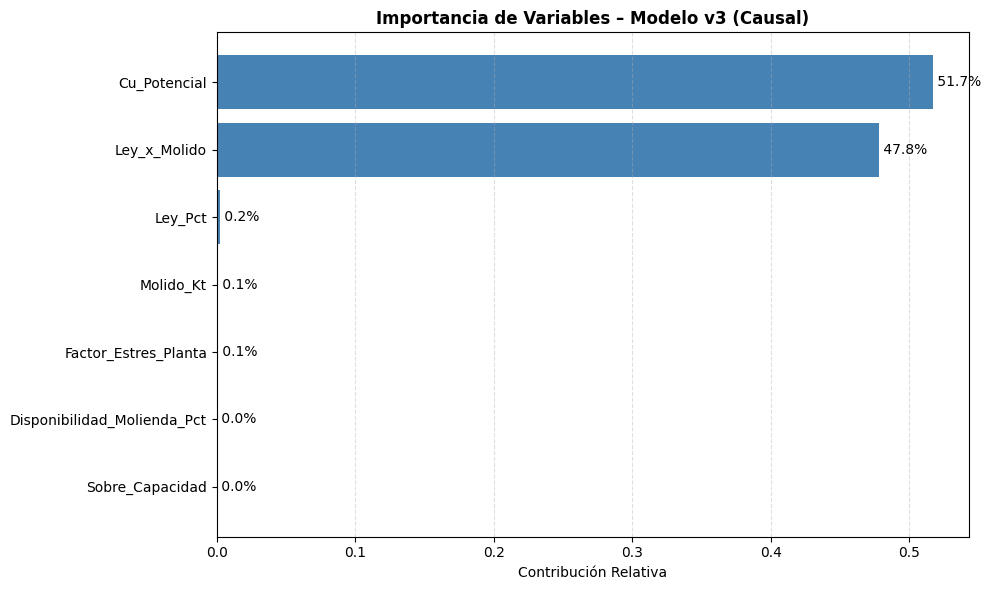

In [13]:
# =========================================================
# MODELO RANDOM FOREST – VERSION CORREGIDA Y CAUSAL
# Objetivo: Cu_Fino_Recuperado_t
# =========================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

# ---------------------------------------------------------
# 1. INGENIERÍA DE VARIABLES (CAUSAL)
# ---------------------------------------------------------

# 1.1 Potencial de cobre alimentado (físico, previo al proceso)
# Representa "cuánto cobre entra" al sistema
df_limpio['Cu_Potencial'] = df_limpio['Ley_Pct'] * df_limpio['Molido_Kt']

# 1.2 Interacción Ley x Molido (no linealidad operativa)
df_limpio['Ley_x_Molido'] = df_limpio['Ley_Pct'] * df_limpio['Molido_Kt']

# 1.3 Estrés de planta (operación forzada)
capacidad_nominal = 150  # Kt/día (detectado en EDA)
df_limpio['Sobre_Capacidad'] = (df_limpio['Molido_Kt'] > capacidad_nominal).astype(int)

# 1.4 Factor continuo de estrés (mejor que binario)
df_limpio['Factor_Estres_Planta'] = (
    df_limpio['Molido_Kt'] / capacidad_nominal
).clip(upper=1.3)

# ---------------------------------------------------------
# 2. DEFINICIÓN DE FEATURES (SIN FUGA DE INFORMACIÓN)
# ---------------------------------------------------------

features_corregidos = [
    'Cu_Potencial',
    'Ley_x_Molido',
    'Ley_Pct',
    'Molido_Kt',
    'Disponibilidad_Molienda_Pct',
    'Sobre_Capacidad',
    'Factor_Estres_Planta'
]

X = df_limpio[features_corregidos]
y = df_limpio['Cu_Fino_Recuperado_t']

# ---------------------------------------------------------
# 3. TRAIN / TEST SPLIT (REPRODUCIBLE)
# ---------------------------------------------------------

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

# ---------------------------------------------------------
# 4. ENTRENAMIENTO DEL MODELO
# ---------------------------------------------------------

modelo_v3 = RandomForestRegressor(
    n_estimators=300,
    max_depth=18,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

modelo_v3.fit(X_train, y_train)

# ---------------------------------------------------------
# 5. EVALUACIÓN
# ---------------------------------------------------------

predicciones = modelo_v3.predict(X_test)

print('--- Desempeño del Modelo ---')
print(f'R2 Test : {r2_score(y_test, predicciones):.4f}')
print(f'MAE Test: {mean_absolute_error(y_test, predicciones):.2f} t')

# ---------------------------------------------------------
# 6. IMPORTANCIA DE VARIABLES
# ---------------------------------------------------------

importancias = modelo_v3.feature_importances_

df_importancia = (
    pd.DataFrame({
        'Variable': features_corregidos,
        'Importancia': importancias
    })
    .sort_values(by='Importancia', ascending=True)
)

plt.figure(figsize=(10, 6))
plt.barh(df_importancia['Variable'], df_importancia['Importancia'], color='steelblue')
plt.title('Importancia de Variables – Modelo v3 (Causal)', fontweight='bold')
plt.xlabel('Contribución Relativa')
plt.grid(axis='x', linestyle='--', alpha=0.4)

for i, v in enumerate(df_importancia['Importancia']):
    plt.text(v, i, f' {v*100:.1f}%', va='center')

plt.tight_layout()
plt.show()



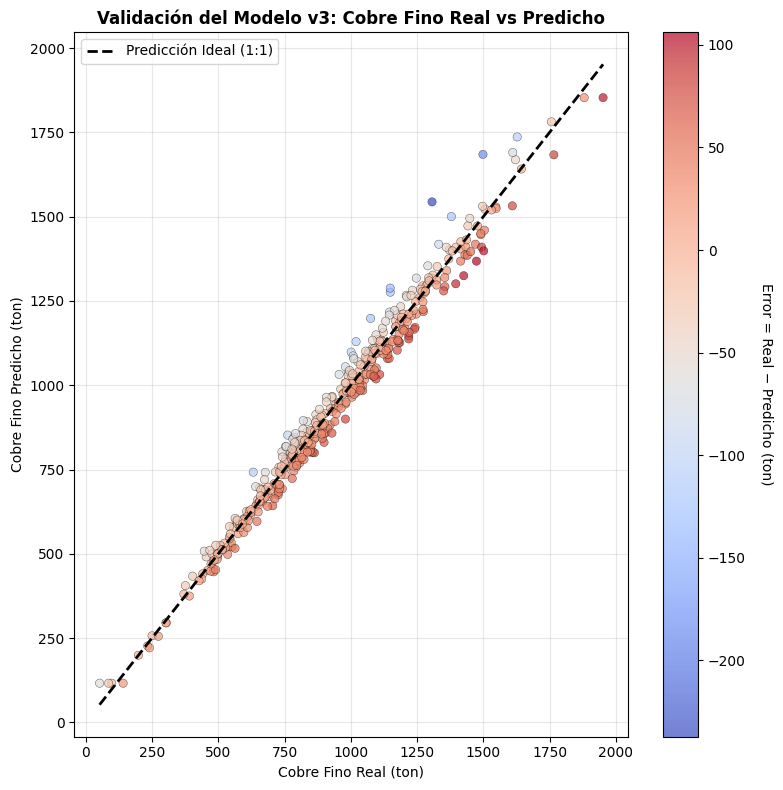

In [14]:
# =========================================================
# VALIDACIÓN DEL MODELO v3 – Real vs Predicho
# Objetivo: Cu_Fino_Recuperado_t
# =========================================================

import matplotlib.pyplot as plt
import numpy as np

# ---------------------------------------------------------
# 1. CÁLCULO DE ERRORES
# ---------------------------------------------------------
errores = y_test - predicciones

# ---------------------------------------------------------
# 2. GRÁFICO REAL VS PREDICHO (COLOREADO POR ERROR)
# ---------------------------------------------------------
plt.figure(figsize=(8, 8))

sc = plt.scatter(
    y_test,
    predicciones,
    c=errores,
    cmap='coolwarm',
    alpha=0.7,
    edgecolor='k',
    linewidth=0.3
)

# Línea ideal 1:1
min_val = min(y_test.min(), predicciones.min())
max_val = max(y_test.max(), predicciones.max())

plt.plot(
    [min_val, max_val],
    [min_val, max_val],
    'k--',
    lw=2,
    label='Predicción Ideal (1:1)'
)

# Barra de color (error)
cbar = plt.colorbar(sc)
cbar.set_label('Error = Real − Predicho (ton)', rotation=270, labelpad=20)

# Etiquetas y formato
plt.title('Validación del Modelo v3: Cobre Fino Real vs Predicho', fontweight='bold')
plt.xlabel('Cobre Fino Real (ton)')
plt.ylabel('Cobre Fino Predicho (ton)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


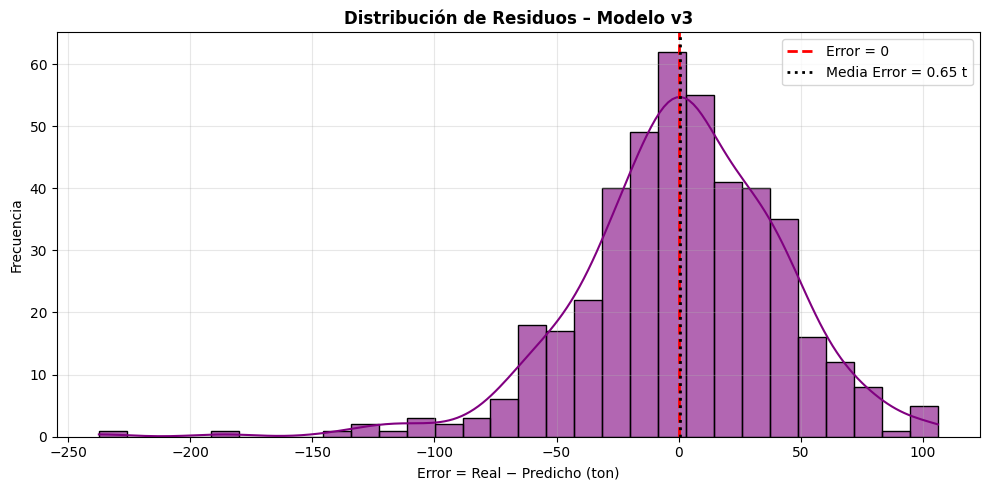

Media del residuo (sesgo): 0.65 t
Desviación estándar del residuo: 41.72 t
Error absoluto medio (aprox): 30.96 t


In [15]:
# =========================================================
# ANÁLISIS DE RESIDUOS – MODELO v3
# Objetivo: Cu_Fino_Recuperado_t
# =========================================================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ---------------------------------------------------------
# 1. Cálculo de residuos
# ---------------------------------------------------------
residuos = y_test - predicciones

media_residuo = residuos.mean()
std_residuo = residuos.std()

# ---------------------------------------------------------
# 2. Histograma + KDE
# ---------------------------------------------------------
plt.figure(figsize=(10, 5))

sns.histplot(
    residuos,
    bins=30,
    kde=True,
    color='purple',
    alpha=0.6
)

# Línea en cero (modelo perfecto)
plt.axvline(0, color='red', linestyle='--', linewidth=2, label='Error = 0')

# Media del error (sesgo)
plt.axvline(
    media_residuo,
    color='black',
    linestyle=':',
    linewidth=2,
    label=f'Media Error = {media_residuo:.2f} t'
)

# Etiquetas
plt.title('Distribución de Residuos – Modelo v3', fontweight='bold')
plt.xlabel('Error = Real − Predicho (ton)')
plt.ylabel('Frecuencia')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# 3. Diagnóstico rápido en texto
# ---------------------------------------------------------
print(f"Media del residuo (sesgo): {media_residuo:.2f} t")
print(f"Desviación estándar del residuo: {std_residuo:.2f} t")
print(f"Error absoluto medio (aprox): {np.mean(np.abs(residuos)):.2f} t")


In [18]:
# ===============================
# ENTRENAMIENTO DEL MODELO FINAL
# ===============================
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# Variables del modelo (las corregidas)
features_corregidos = [
    'Ley_Pct',
    'Molido_Kt',
    'Disponibilidad_Molienda_Pct',
    'Sobre_Capacidad',
    'Factor_Estres_Planta'
]

X = df_limpio[features_corregidos]
y = df_limpio['Cu_Fino_Recuperado_t']

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Modelo
modelo_v2 = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

modelo_v2.fit(X_train, y_train)

from sklearn.model_selection import cross_val_score
import numpy as np

scores = cross_val_score(
    modelo_v2,
    X,
    y,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

print(f"R2 promedio en Cross-Validation: {scores.mean():.4f}")
print(f"Desviación estándar del R2: {scores.std():.4f}")
print(f"R2 mínimo: {scores.min():.4f}")
print(f"R2 máximo: {scores.max():.4f}")



R2 promedio en Cross-Validation: 0.9646
Desviación estándar del R2: 0.0215
R2 mínimo: 0.9232
R2 máximo: 0.9842


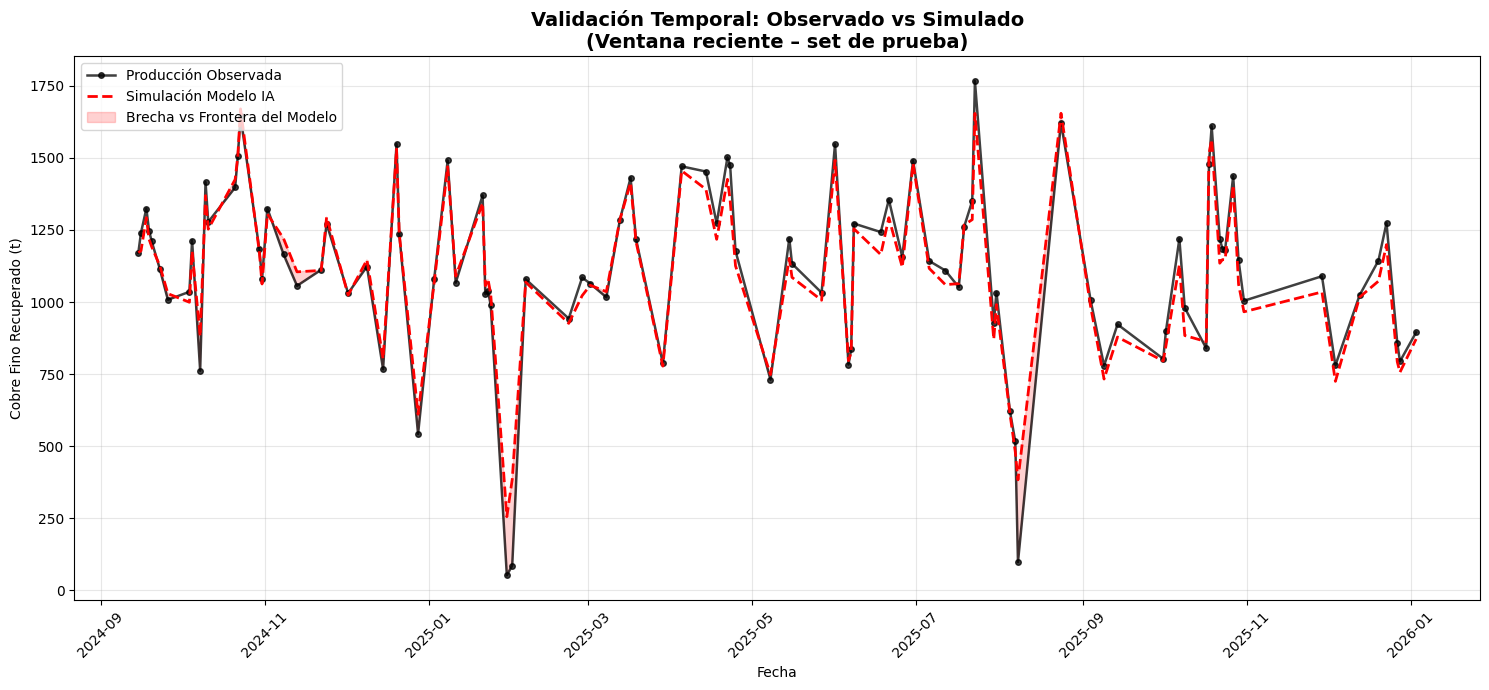

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# ===============================
# DATAFRAME DE VALIDACIÓN
# ===============================
df_validacion = df_limpio.loc[y_test.index].copy()
df_validacion['Real'] = y_test
df_validacion['Predicho'] = modelo_v2.predict(X_test)

# Orden temporal correcto
df_validacion = df_validacion.sort_values('Fecha')

# Seleccionamos ventana reciente
df_plot = df_validacion.tail(100)

# ===============================
# GRÁFICO
# ===============================
plt.figure(figsize=(15, 7))

# Serie real
plt.plot(
    df_plot['Fecha'],
    df_plot['Real'],
    label='Producción Observada',
    color='black',
    linewidth=1.8,
    marker='o',
    markersize=4,
    alpha=0.75
)

# Serie simulada
plt.plot(
    df_plot['Fecha'],
    df_plot['Predicho'],
    label='Simulación Modelo IA',
    color='red',
    linestyle='--',
    linewidth=2
)

# ===============================
# BRECHA (NO LLAMAR PÉRDIDA)
# Solo cuando el modelo predice MÁS que lo observado
# ===============================
plt.fill_between(
    df_plot['Fecha'],
    df_plot['Real'],
    df_plot['Predicho'],
    where=(df_plot['Predicho'] > df_plot['Real']),
    interpolate=True,
    color='red',
    alpha=0.18,
    label='Brecha vs Frontera del Modelo'
)

# ===============================
# ESTÉTICA
# ===============================
plt.title(
    'Validación Temporal: Observado vs Simulado\n(Ventana reciente – set de prueba)',
    fontsize=14,
    fontweight='bold'
)
plt.xlabel('Fecha')
plt.ylabel('Cobre Fino Recuperado (t)')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


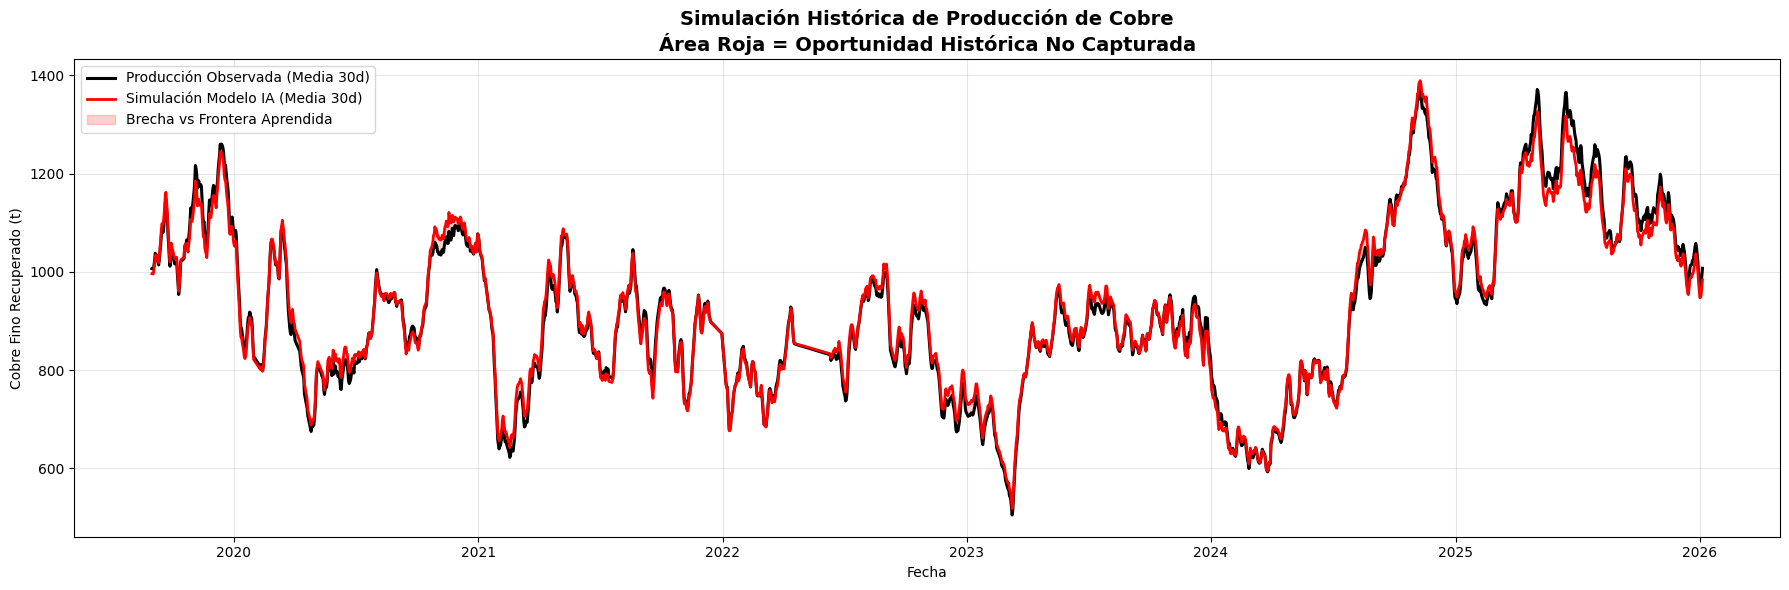

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# ===============================
# 1. ORDEN Y COPIA SEGURA
# ===============================
df_limpio = df_limpio.sort_values('Fecha').copy()

# ===============================
# 2. PREDICCIÓN TOTAL DEL MODELO
# ===============================
df_limpio['Produccion_Simulada'] = modelo_v2.predict(
    df_limpio[features_corregidos]
)

# Brecha (NO es pérdida)
df_limpio['Brecha_Modelo'] = (
    df_limpio['Produccion_Simulada'] - df_limpio['Cu_Fino_Recuperado_t']
)

# ===============================
# 3. SUAVIZADO (LECTURA EJECUTIVA)
# ===============================
window = 30  # días
df_limpio['Real_30d'] = df_limpio['Cu_Fino_Recuperado_t'].rolling(window).mean()
df_limpio['Sim_30d'] = df_limpio['Produccion_Simulada'].rolling(window).mean()

# ===============================
# 4. GRÁFICO PRINCIPAL
# ===============================
plt.figure(figsize=(18, 6))

plt.plot(
    df_limpio['Fecha'],
    df_limpio['Real_30d'],
    label='Producción Observada (Media 30d)',
    color='black',
    linewidth=2.2
)

plt.plot(
    df_limpio['Fecha'],
    df_limpio['Sim_30d'],
    label='Simulación Modelo IA (Media 30d)',
    color='red',
    linewidth=2
)

plt.fill_between(
    df_limpio['Fecha'],
    df_limpio['Real_30d'],
    df_limpio['Sim_30d'],
    where=(df_limpio['Sim_30d'] > df_limpio['Real_30d']),
    interpolate=True,
    color='red',
    alpha=0.18,
    label='Brecha vs Frontera Aprendida'
)

plt.title(
    'Simulación Histórica de Producción de Cobre\n'
    'Área Roja = Oportunidad Histórica No Capturada',
    fontsize=14,
    fontweight='bold'
)

plt.xlabel('Fecha')
plt.ylabel('Cobre Fino Recuperado (t)')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



In [22]:
# ============================================
# ERROR (SESGO) ACUMULADO DEL MODELO
# Interpretación: sesgo sistemático de la frontera aprendida
# ============================================

# Usamos el dataframe de validación temporal ya construido
# (Real vs Produccion_Simulada)
produccion_real_acum = df_validacion['Real'].sum()
produccion_modelo_acum = df_validacion['Predicho'].sum()

# Sesgo absoluto (toneladas)
sesgo_total_t = produccion_modelo_acum - produccion_real_acum

# Sesgo relativo (%)
sesgo_porcentual = (sesgo_total_t / produccion_real_acum) * 100

print(f"Producción Real Acumulada (Test): {produccion_real_acum:,.2f} t")
print(f"Producción según Modelo IA:       {produccion_modelo_acum:,.2f} t")

print(
    f"Sesgo Total del Modelo: {sesgo_porcentual:+.2f}% "
    f"({sesgo_total_t:+,.1f} t)"
)

# Lectura ejecutiva rápida
if abs(sesgo_porcentual) < 2:
    print("✔ El modelo está bien calibrado a nivel agregado.")
elif sesgo_porcentual > 0:
    print("▲ El modelo tiende a SOBRE-estimar la frontera productiva.")
else:
    print("▼ El modelo tiende a SUB-estimar el potencial productivo.")


Producción Real Acumulada (Test): 412,234.51 t
Producción según Modelo IA:       412,641.10 t
Sesgo Total del Modelo: +0.10% (+406.6 t)
✔ El modelo está bien calibrado a nivel agregado.


In [23]:
import pandas as pd

# =====================================
# 1. COPIA SEGURA Y FECHA COMO DATETIME
# =====================================
df_val = df_validacion.copy()
df_val['Fecha'] = pd.to_datetime(df_val['Fecha'])

# =====================================
# 2. SESGO ANUAL (%)
# =====================================
sesgo_anual = (
    df_val
    .groupby(df_val['Fecha'].dt.year)
    .apply(
        lambda x: (x['Predicho'].sum() - x['Real'].sum())
        / x['Real'].sum() * 100
    )
    .rename('Sesgo_%')
)

print('📊 Sesgo anual del modelo (%)')
print(sesgo_anual.round(2))

# =====================================
# 3. SESGO MENSUAL (%)
# =====================================
sesgo_mensual = (
    df_val
    .groupby(df_val['Fecha'].dt.to_period('M'))
    .apply(
        lambda x: (x['Predicho'].sum() - x['Real'].sum())
        / x['Real'].sum() * 100
    )
    .rename('Sesgo_%')
)

print('\n📊 Sesgo mensual del modelo (%)')
print(sesgo_mensual.round(2))


📊 Sesgo anual del modelo (%)
Fecha
2019   -1.71
2020    1.30
2021    1.31
2022    1.63
2023   -0.61
2024    0.62
2025   -1.78
2026   -2.58
Name: Sesgo_%, dtype: float64

📊 Sesgo mensual del modelo (%)
Fecha
2019-07   -0.70
2019-09   -1.26
2019-10   -3.87
2019-11    0.13
2019-12   -1.15
           ... 
2025-09   -4.13
2025-10   -3.60
2025-11   -5.01
2025-12   -5.30
2026-01   -2.58
Freq: M, Name: Sesgo_%, Length: 76, dtype: float64


In [24]:
# ======================================
# APLICACIÓN DEL MODELO PARA PREDICCIÓN
# ======================================
import pandas as pd
import numpy as np

# --------------------------------------
# 1. DATOS DE ENTRADA (Plan diario)
# --------------------------------------
data_manana = {
    'Ley_Pct': [0.012212],                 # 1.22 % Ley
    'Molido_Kt': [158.888],                # Kt/día
    'Disponibilidad_Molienda_Pct': [1.00] # 100 % disponibilidad
}

df_pred = pd.DataFrame(data_manana)

# --------------------------------------
# 2. FEATURE ENGINEERING (MISMO QUE TRAIN)
# --------------------------------------

# Capacidad nominal aprendida del EDA
CAPACIDAD_NOMINAL = 150

# Stress operativo
df_pred['Sobre_Capacidad'] = (
    df_pred['Molido_Kt'] > CAPACIDAD_NOMINAL
).astype(int)

# Factor continuo de estrés de planta
df_pred['Factor_Estres_Planta'] = (
    df_pred['Molido_Kt'] / CAPACIDAD_NOMINAL
)

# --------------------------------------
# 3. FEATURES FINALES (orden exacto)
# --------------------------------------
features_corregidos = [
    'Ley_Pct',
    'Molido_Kt',
    'Disponibilidad_Molienda_Pct',
    'Sobre_Capacidad',
    'Factor_Estres_Planta'
]

X_pred = df_pred[features_corregidos]

# --------------------------------------
# 4. PREDICCIÓN
# --------------------------------------
prediccion_fino = modelo_v2.predict(X_pred)

print('--- RESULTADO DE SIMULACIÓN IA ---')
print(f"Producción estimada de Cu Fino: {prediccion_fino[0]:,.2f} toneladas")


--- RESULTADO DE SIMULACIÓN IA ---
Producción estimada de Cu Fino: 1,736.66 toneladas


In [25]:
# ===============================
# GUARDADO DEL MODELO FINAL
# ===============================
import joblib

# Diccionario completo del artefacto del modelo
artefacto_modelo = {
    'modelo': modelo_v2,
    'features': features_corregidos,
    'descripcion': (
        'Modelo Random Forest para predicción de Cu Fino Recuperado.\n'
        'Variables físicas: Ley, Molienda, Disponibilidad.\n'
        'Incluye variables derivadas de estrés de planta.\n'
        'Modelo calibrado sin fuga de información.'
    )
}

# Guardar en disco
joblib.dump(artefacto_modelo, 'modelo_produccion_cu_rf_v3.pkl')

print("✅ Modelo guardado correctamente como 'modelo_produccion_cu_rf_v3.pkl'")



✅ Modelo guardado correctamente como 'modelo_produccion_cu_rf_v3.pkl'


In [26]:
# ===============================
# CARGA DEL MODELO
# ===============================
import joblib

artefacto = joblib.load('modelo_produccion_cu_rf_v3.pkl')

modelo_cargado = artefacto['modelo']
features_modelo = artefacto['features']

print("Modelo cargado correctamente")
print("Features usadas por el modelo:")
print(features_modelo)


Modelo cargado correctamente
Features usadas por el modelo:
['Ley_Pct', 'Molido_Kt', 'Disponibilidad_Molienda_Pct', 'Sobre_Capacidad', 'Factor_Estres_Planta']


In [36]:
import pandas as pd
import numpy as np

# ===============================
# 1. CREAR PLAN MENSUAL BASE
# ===============================
fechas = pd.date_range(start='2026-01-01', end='2026-01-31')

df_plan = pd.DataFrame({
    'Fecha': fechas,
    'Ley_Pct': np.random.uniform(0.009, 0.013, len(fechas)),
    'Molido_Kt': np.random.uniform(140, 160, len(fechas)),
    'Disponibilidad_Molienda_Pct': np.random.uniform(0.92, 0.99, len(fechas))
})

# ===============================
# 2. SIMULAR PARADA DE PLANTA
# ===============================
df_plan.loc[df_plan['Fecha'] == '2026-01-15', [
    'Molido_Kt',
    'Disponibilidad_Molienda_Pct'
]] = 0

# ===============================
# 3. GUARDAR CSV BASE
# ===============================
nombre_csv = 'plan_base_enero_2026.csv'
df_plan.to_csv(nombre_csv, index=False)

print(f"✅ CSV BASE creado: {nombre_csv}")
df_plan.head()



✅ CSV BASE creado: plan_base_enero_2026.csv


,Fecha,Ley_Pct,Molido_Kt,Disponibilidad_Molienda_Pct
0,2026-01-01,0.011847,158.673049,0.959790
1,2026-01-02,0.011466,159.536262,0.954461
2,2026-01-03,0.009638,158.443772,0.971139
3,2026-01-04,0.009626,151.697833,0.972017
4,2026-01-05,0.011828,158.950013,0.936015


In [37]:
import pandas as pd
import joblib
import io
from google.colab import files

# ===============================
# 1. SUBIR MODELO ENTRENADO
# ===============================
print("📂 Sube el archivo del modelo (.pkl):")
uploaded_model = files.upload()

obj = joblib.load(
    io.BytesIO(uploaded_model[list(uploaded_model.keys())[0]])
)

# Extraer modelo si viene empaquetado
modelo = obj['modelo'] if isinstance(obj, dict) else obj
print("🤖 Modelo cargado correctamente")

# ===============================
# 2. SUBIR CSV BASE
# ===============================
print("\n📂 Sube el CSV base del plan:")
uploaded_csv = files.upload()
nombre_csv = list(uploaded_csv.keys())[0]

plan = pd.read_csv(io.BytesIO(uploaded_csv[nombre_csv]))

# ===============================
# 3. FEATURE ENGINEERING (INTERNO)
# ===============================

# Sobrecapacidad
plan['Sobre_Capacidad'] = (plan['Molido_Kt'] > 150).astype(int)

# Estrés de planta (proxy aprendido)
plan['Factor_Estres_Planta'] = (
    plan['Sobre_Capacidad'] *
    (1 - plan['Disponibilidad_Molienda_Pct'])
)

# ===============================
# 4. FEATURES EXACTAS DEL MODELO
# ===============================
features_corregidos = [
    'Ley_Pct',
    'Molido_Kt',
    'Disponibilidad_Molienda_Pct',
    'Sobre_Capacidad',
    'Factor_Estres_Planta'
]

# ===============================
# 5. PREDICCIÓN
# ===============================
plan['Cu_Fino_Predicho_t'] = modelo.predict(plan[features_corregidos])

# ===============================
# 6. RESULTADOS
# ===============================
produccion_total = plan['Cu_Fino_Predicho_t'].sum()

print("\n📊 RESULTADOS DEL PLAN")
print(f"Producción total estimada: {produccion_total:,.2f} t Cu Fino")

display(plan.head())


📂 Sube el archivo del modelo (.pkl):


Saving modelo_produccion_cu_rf_v3.pkl to modelo_produccion_cu_rf_v3 (1).pkl
🤖 Modelo cargado correctamente

📂 Sube el CSV base del plan:


Saving plan_base_enero_2026.csv to plan_base_enero_2026 (1).csv

📊 RESULTADOS DEL PLAN
Producción total estimada: 34,910.99 t Cu Fino


,Fecha,Ley_Pct,Molido_Kt,Disponibilidad_Molienda_Pct,Sobre_Capacidad,Factor_Estres_Planta,Cu_Fino_Predicho_t
0,2026-01-01,0.011847,158.673049,0.959790,1,0.040210,1352.593352
1,2026-01-02,0.011466,159.536262,0.954461,1,0.045539,1335.289596
2,2026-01-03,0.009638,158.443772,0.971139,1,0.028861,964.164531
3,2026-01-04,0.009626,151.697833,0.972017,1,0.027983,930.393363
4,2026-01-05,0.011828,158.950013,0.936015,1,0.063985,1350.097037


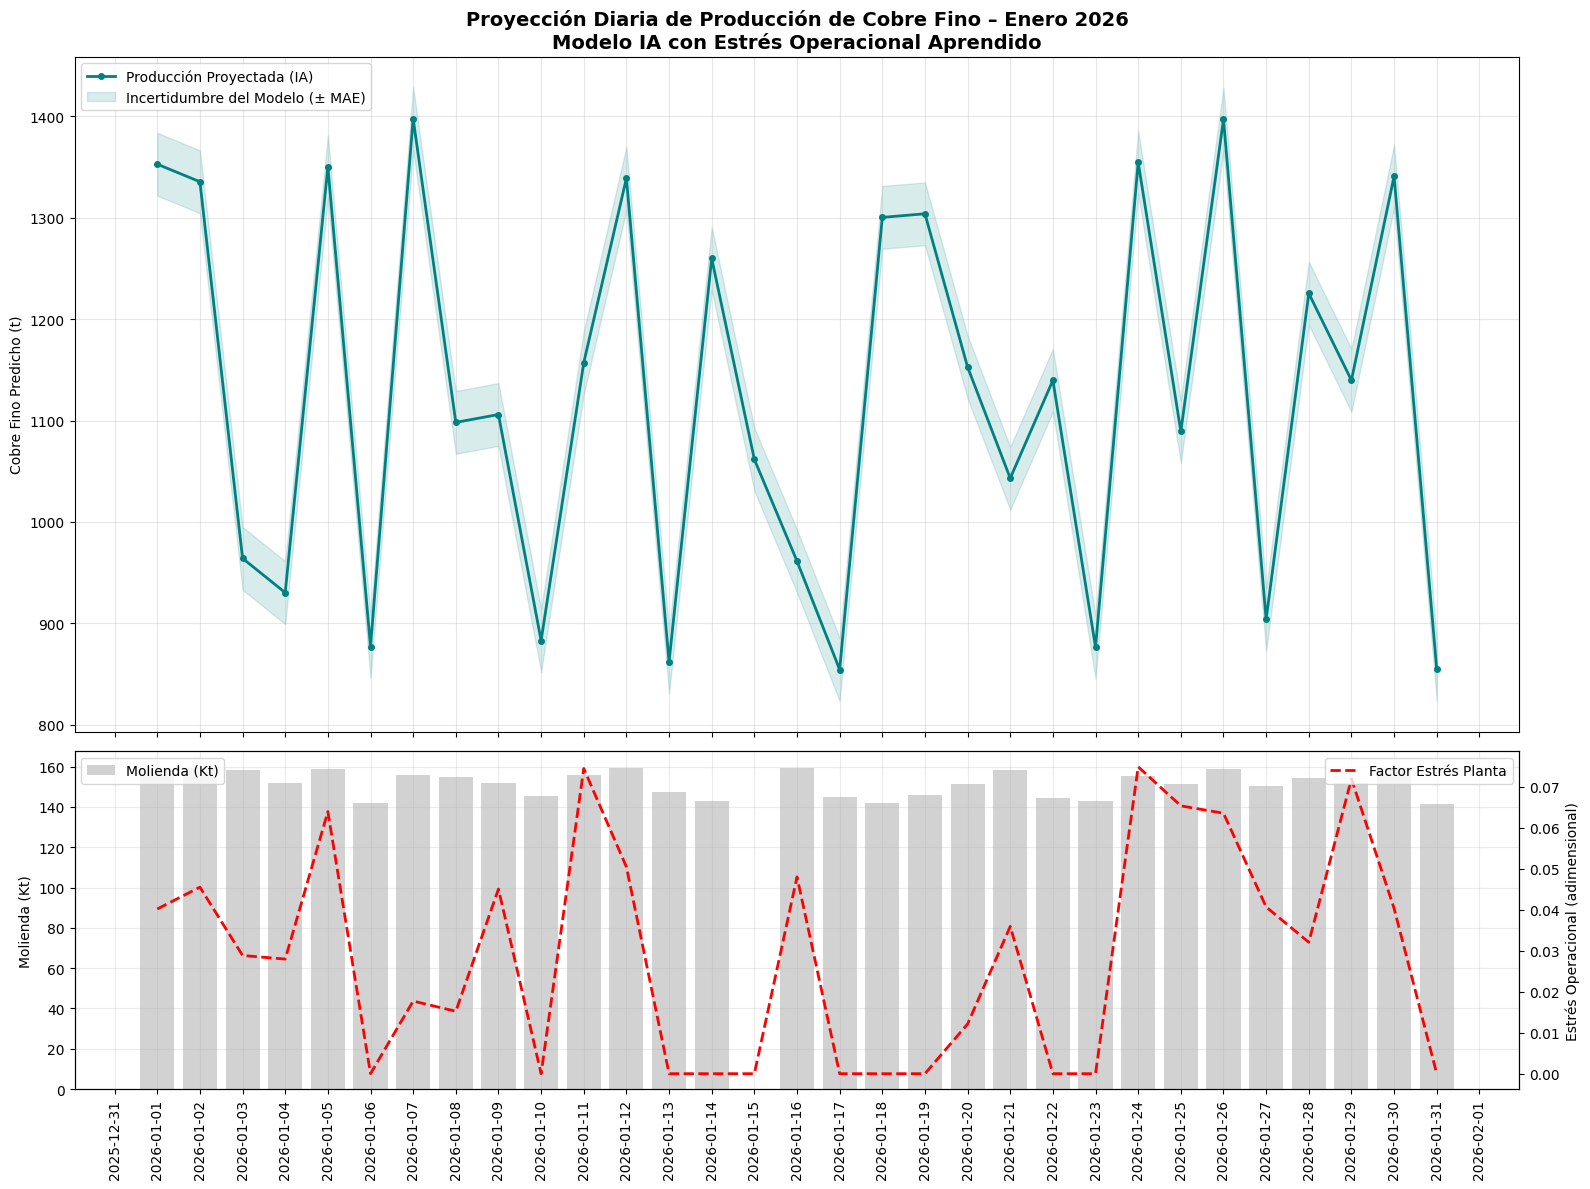

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ===============================
# 1. ASEGURAR FECHA
# ===============================
plan['Fecha'] = pd.to_datetime(plan['Fecha'])

# ===============================
# 2. PARÁMETROS DEL MODELO
# ===============================
MAE_MODELO = 30.96  # t (obtenido en validación)

# ===============================
# 3. CREAR FIGURA
# ===============================
fig, (ax1, ax2) = plt.subplots(
    2, 1,
    figsize=(16, 12),
    sharex=True,
    gridspec_kw={'height_ratios': [2, 1]}
)

# ===============================
# GRÁFICO 1: PRODUCCIÓN PROYECTADA
# ===============================
ax1.plot(
    plan['Fecha'],
    plan['Cu_Fino_Predicho_t'],
    marker='o',
    markersize=4,
    color='teal',
    linewidth=2,
    label='Producción Proyectada (IA)'
)

# Banda de incertidumbre (MAE)
ax1.fill_between(
    plan['Fecha'],
    plan['Cu_Fino_Predicho_t'] - MAE_MODELO,
    plan['Cu_Fino_Predicho_t'] + MAE_MODELO,
    color='teal',
    alpha=0.15,
    label='Incertidumbre del Modelo (± MAE)'
)

ax1.set_title(
    'Proyección Diaria de Producción de Cobre Fino – Enero 2026\n'
    'Modelo IA con Estrés Operacional Aprendido',
    fontsize=14,
    fontweight='bold'
)
ax1.set_ylabel('Cobre Fino Predicho (t)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# ===============================
# GRÁFICO 2: DRIVERS OPERACIONALES
# ===============================

# Molienda
ax2.bar(
    plan['Fecha'],
    plan['Molido_Kt'],
    color='gray',
    alpha=0.35,
    label='Molienda (Kt)'
)

# Eje secundario: Estrés de Planta
ax2_twin = ax2.twinx()
ax2_twin.plot(
    plan['Fecha'],
    plan['Factor_Estres_Planta'],
    color='red',
    linestyle='--',
    linewidth=2,
    label='Factor Estrés Planta'
)

ax2.set_ylabel('Molienda (Kt)')
ax2_twin.set_ylabel('Estrés Operacional (adimensional)')

ax2.legend(loc='upper left')
ax2_twin.legend(loc='upper right')

# ===============================
# FORMATO DE FECHAS
# ===============================
ax2.xaxis.set_major_locator(mdates.DayLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.setp(ax2.get_xticklabels(), rotation=90, ha='center')

ax2.grid(True, alpha=0.25)

plt.tight_layout()
plt.show()


/tmp/ipython-input-3333853516.py:121: UserWarning: Glyph 8419 (\N{COMBINING ENCLOSING KEYCAP}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8419 (\N{COMBINING ENCLOSING KEYCAP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


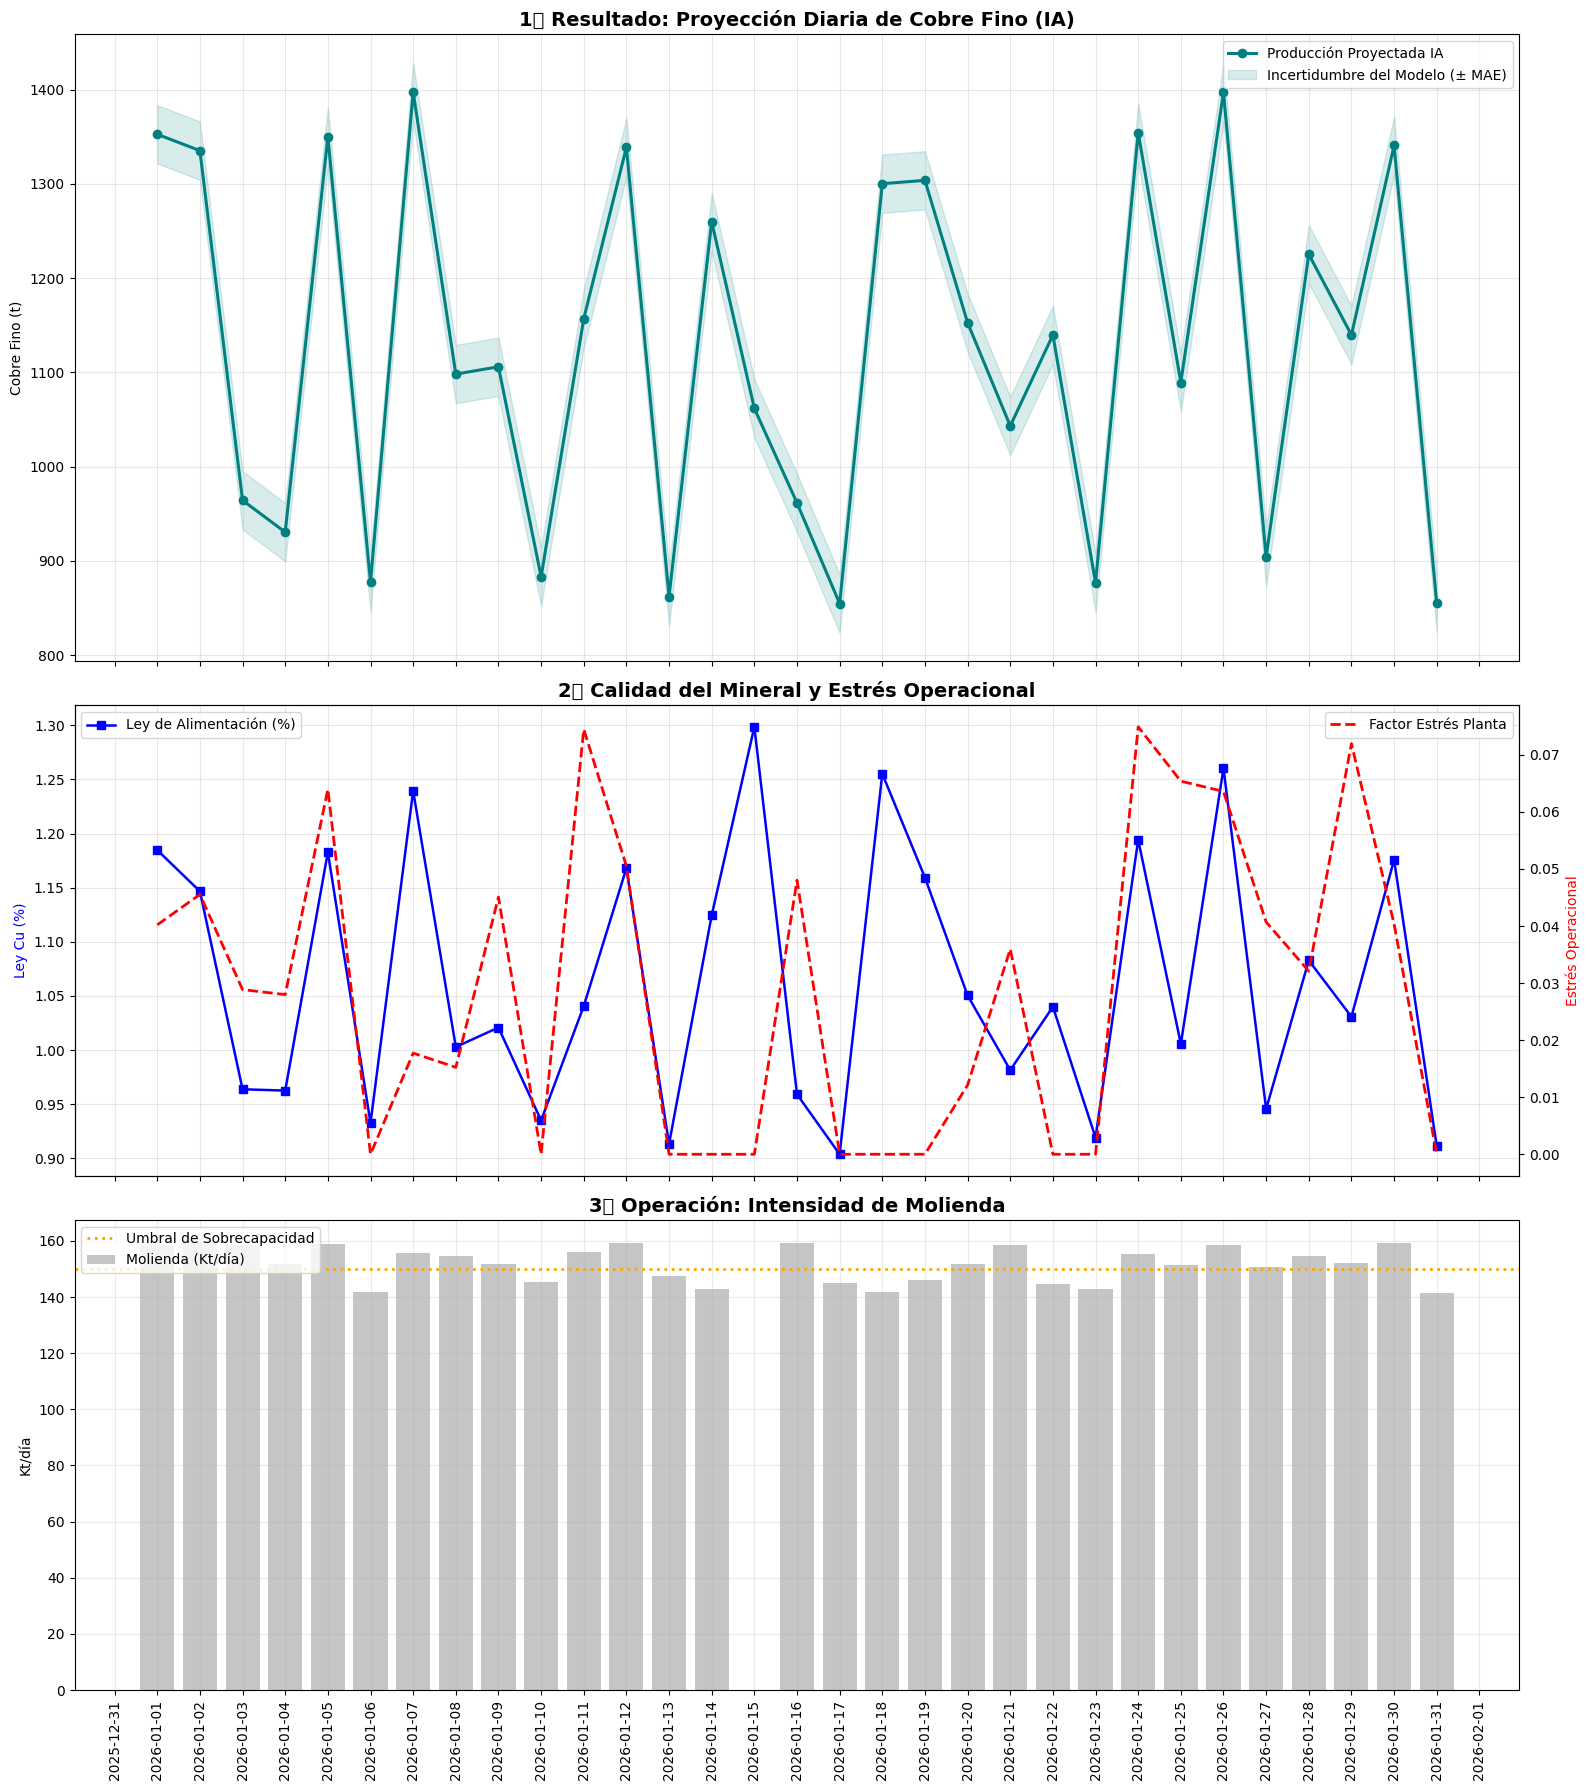

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ===============================
# 1. PREPARACIÓN
# ===============================
plan['Fecha'] = pd.to_datetime(plan['Fecha'])

MAE_MODELO = 30.96  # t (obtenido en validación real)

# ===============================
# 2. PANEL DE 3 GRÁFICOS
# ===============================
fig, (ax1, ax2, ax3) = plt.subplots(
    3, 1,
    figsize=(16, 18),
    sharex=True,
    gridspec_kw={'height_ratios': [2, 1.5, 1.5]}
)

# ===============================
# GRÁFICO 1: RESULTADO FINAL
# ===============================
ax1.plot(
    plan['Fecha'],
    plan['Cu_Fino_Predicho_t'],
    marker='o',
    color='teal',
    linewidth=2.2,
    label='Producción Proyectada IA'
)

ax1.fill_between(
    plan['Fecha'],
    plan['Cu_Fino_Predicho_t'] - MAE_MODELO,
    plan['Cu_Fino_Predicho_t'] + MAE_MODELO,
    color='teal',
    alpha=0.15,
    label='Incertidumbre del Modelo (± MAE)'
)

ax1.set_title(
    '1️⃣ Resultado: Proyección Diaria de Cobre Fino (IA)',
    fontsize=14,
    fontweight='bold'
)
ax1.set_ylabel('Cobre Fino (t)')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# ===============================
# GRÁFICO 2: CALIDAD + ESTRÉS
# ===============================
ax2.plot(
    plan['Fecha'],
    plan['Ley_Pct'] * 100,
    color='blue',
    marker='s',
    linewidth=1.8,
    label='Ley de Alimentación (%)'
)

ax2_twin = ax2.twinx()
ax2_twin.plot(
    plan['Fecha'],
    plan['Factor_Estres_Planta'],
    color='red',
    linestyle='--',
    linewidth=2,
    label='Factor Estrés Planta'
)

ax2.set_title(
    '2️⃣ Calidad del Mineral y Estrés Operacional',
    fontsize=14,
    fontweight='bold'
)
ax2.set_ylabel('Ley Cu (%)', color='blue')
ax2_twin.set_ylabel('Estrés Operacional', color='red')

ax2.grid(True, alpha=0.3)
ax2.legend(loc='upper left')
ax2_twin.legend(loc='upper right')

# ===============================
# GRÁFICO 3: INTENSIDAD OPERATIVA
# ===============================
ax3.bar(
    plan['Fecha'],
    plan['Molido_Kt'],
    color='gray',
    alpha=0.45,
    label='Molienda (Kt/día)'
)

ax3.axhline(
    150,
    color='orange',
    linestyle=':',
    linewidth=2,
    label='Umbral de Sobrecapacidad'
)

ax3.set_title(
    '3️⃣ Operación: Intensidad de Molienda',
    fontsize=14,
    fontweight='bold'
)
ax3.set_ylabel('Kt/día')
ax3.legend(loc='upper left')
ax3.grid(True, alpha=0.25)

# ===============================
# FORMATO DE FECHAS
# ===============================
ax3.xaxis.set_major_locator(mdates.DayLocator())
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.setp(ax3.get_xticklabels(), rotation=90, ha='center')

plt.tight_layout()
plt.show()
